In [1]:
import os

import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import scipy.signal as sg

In [2]:
dataset_loc = "../ptb-xl"

In [4]:
all_signals = np.load(os.path.join(dataset_loc, "100_hz.npz"))

In [5]:
all_signals

In [7]:
dir(all_signals)

['__abstractmethods__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_files',
 'allow_pickle',
 'close',
 'f',
 'fid',
 'files',
 'get',
 'items',
 'keys',
 'max_header_size',
 'pickle_kwargs',
 'values',
 'zip']

In [11]:
data_np = all_signals['arr_0']

In [48]:
@numba.jit
def remove_baseline_ecg(signal, wavelet='db6', level=6):
    result = np.zeros_like(signal)
    for i in range(signal.shape[0]):
        coeffs = pywt.wavedec(signal[i], wavelet, level=level)
        coeffs[0] *= 0
        result[i, :] = pywt.waverec(coeffs, wavelet)
    return result

C:\Users\razan\AppData\Local\Temp\ipykernel_9660\3685254558.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def remove_baseline_ecg(signal, wavelet='db6', level=6):


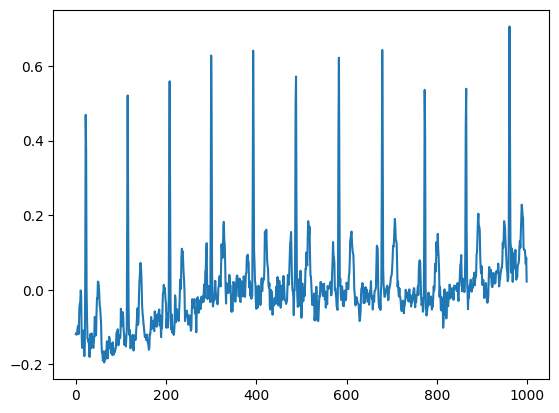

In [49]:
data_np[0].shape

plt.plot(data_np[0][0])

In [54]:
%%time
sig_transformed = remove_baseline_ecg(data_np[0])
sig_transformed.shape

CPU times: total: 0 ns
Wall time: 5.57 ms


(12, 1000)

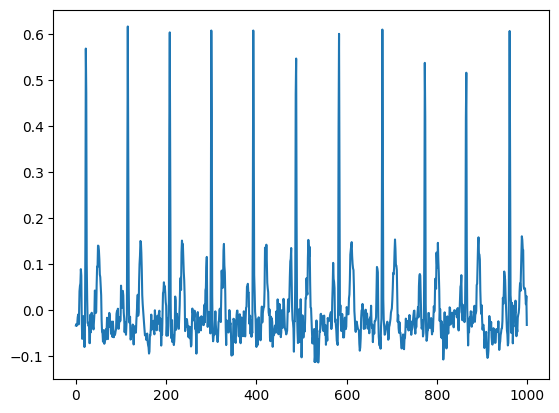

In [55]:
plt.plot(sig_transformed[0])

In [61]:
@numba.jit(parallel=True)
def remove_baseline_for_all(data_np):
    results = np.zeros_like(data_np)
    num_records = data_np.shape[0]
    
    for i in range(num_records):
        results[i] = remove_baseline_ecg(data_np[i])
    
    return results

C:\Users\razan\AppData\Local\Temp\ipykernel_9660\3743153709.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel=True)


In [66]:
%%time
results = remove_baseline_for_all(data_np)

CPU times: total: 1min 4s
Wall time: 1min 11s


In [67]:
results.shape

(21388, 12, 1000)

In [69]:
np.save(os.path.join(dataset_loc, "baseline_removed_100hz.npy"), results)

In [70]:
results.shape

(21388, 12, 1000)

In [71]:
np.savez_compressed(os.path.join(dataset_loc, "baseline_removed_100hz.npz"), results)